# Chapter 4. Improvement of Word2vec

## 1. Embedding 계층 - (입력-은닉층) 순전파 및 역전파의 불필요한 계산을 생략.

만약 단어의 수가 너무 많을 경우 (i.e. 100만 개 -> Input layer: (1,100만))
Input * Weight 의 행렬곱 연산량이 너무 많다. i.e. (1,100만) * (100만,500)

특정 단어가 입력될 경우 (ID = 0, 1, 2, ..., 100만 에서 j번째 단어라고 가정), <br> 
행렬곱의 연산 결과는 Weight matarix의 j번째 행이 될 것이다.

따라서, 이 계산을 간략화해줄 Embedding 계층을 넣어, 불필요한 계산을 생략하도록 하자.

In [1]:
# Numpy example : 특정 행 뽑아내기
import numpy as np

A = np.arange(21).reshape(7,3)

print(A)
# [idx=0] : 1번째 행 뽑아 내기
A[0]

[[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]
 [12 13 14]
 [15 16 17]
 [18 19 20]]


array([0, 1, 2])

In [2]:
# idx=4 : 5번째 행
A[4]

array([12, 13, 14])

In [3]:
# 특정 행만 뽑아내기 : 3번째, 7번째 행
row_idx = np.array([2,6])
A[row_idx]
# 아래 표현과 동일
# A[[2,6]]
#
# numpy 배열과 일반 배열 모두 작동함!

array([[ 6,  7,  8],
       [18, 19, 20]])

In [4]:
# Embedding 계층 구현

class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None

    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out

    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0
        np.add.at(dW, self.idx, dout) # 중복문제 해결을 위해 해당 행에 할당이 아닌 더하기. dout를 dW의 idx번째 행에 더해줌
        # 아래와 동일한 연산을 수행함.
        # for i, word_id in enumerate(self.idx):
        #   dW[word_id] += dout[i]
        # 일반적으로 파이썬에서 for문 보다는 넘파이의 내장 메서드를 사용하는 편이 더 빠름. 
        
        return None

위의 Embedding 계층이 기존 Word2vec의 matmul 계층을 대체한다. <br> 
(사실 하는 역할 및 연산은 똑같지만, 불필요한 계산을 줄인 것. 메모리 절약 효과도 있다!)

## 2. Softmax 계산 간략화 방법론

### (1) Negative sampling

- (은닉층-출력층) 연산 또한 계산량이 많음.
- softmax의 경우도 연산량이 많음. (exp 연산을 N번 시행, N=단어 개수)

#### (i). 이진 분류로 근사.
    - 출력층 뉴런은 1개만 있고, 이진 분류로 가정. (이 단어냐, 아니냐? Yes or no)
    - Sigmoid 함수로 확률변환, cross-entropy로 cost function 설정.
    
- - -

    - 특정 단어에 대해 1이 정답이라고 가정하면 해당 뉴런 외의 나머지 뉴런에 대해서는 0에 가깝게 나오는 것을 원함.
    - 적은 수의 부정적 예를 샘플링해 사용 (?) : 많은 계산량을 감당하기 힘듬.
    - 정답인 예에 대해 학습하고, 부정적 예 (정답=0) 몇 개 샘플링 (선별)하여 각각의 손실함수의 합을 최종 손실로 한다.
    - 정답 + 오답 각각에 대한 Loss function을 더해서 최종 Loss 구성.

#### (ii). 샘플링 방법
    - 말뭉치의 단어 빈도를 기준으로 샘플링.
    - 많은 빈도수에 대해 더 많이 나오게, 희소할 수록 적게 나오게.

In [5]:
# 샘플링 예시 : np.random.choice로 배열 원소 중 랜덤하게 샘플링.
words = ['you', 'say', 'goodbye', 'I', 'hello', '.']
np.random.choice(words)

'say'

In [6]:
# 랜덤하게 5개 샘플링 (중복 가능)
np.random.choice(words,size=5)

array(['I', 'you', 'goodbye', 'I', 'say'], dtype='<U7')

In [7]:
# 랜덤하게 5개 샘플링 (중복 불가)
np.random.choice(words,size=5,replace=False)

array(['hello', '.', 'say', 'goodbye', 'I'], dtype='<U7')

In [8]:
# 확률 분포에 따른 샘플링
# np.sum(p) == 1 이어야 함!
p = [0.5, 0.1, 0.05, 0.2, 0.05, 0.1]
#print(np.sum(p))
np.random.choice(words, p=p)

'you'

* word2vec 네거티브 샘플링에서는 앞의 확률분포에서 한 가지를 수정하라고 권고 => 기본 확률분포에 0.75 제곱
    * 출연 확률이 낮은 단어를 버리지 않기 위해서.
    * 원래 확률이 낮은 단어의 확률을 살짝 높일 수 있음.
    * 0.75에 이론적 의미는 없으니 다른 값으로 설정해도 됨.
    * $ P^{\prime}(w_i) = \frac{P(w_i)^{0.75}}{\sum^{n}_{j}{P(w_j)^(0.75)}} .$
    
#### Unigram, bigram, trigram, ...
    - 하나의 (연속된) 단어. 바이그램은 2개, 트라이그램은 3개
    - 한 단어를 대상으로 확률분포를 만든다.
    - 바이그램 버전이면, 두 단어로 구성된 대상에 대한 확률분포를 만든다.

In [9]:
# 확률 분포 조정
p = [0.7,0.29,0.01]
new_p = np.power(p,0.75)
new_p /= np.sum(new_p)
print(new_p)

[0.64196878 0.33150408 0.02652714]


In [10]:
# 유용할 수 있는 numpy method: np.c_
# np.c_ : 가로 방향으로 배열을 붙인다.
# 단, 같은 크기의 1차원 array 여러개를 붙일 경우, 각 1차원 배열을 열로 간주하고 {(N,1) 행렬} 세로로 붙임.
A = np.array([1,2,3])
B = np.array([4,5,6])
C = np.array([7,8,9])
print(np.c_[A,B,C])
print(np.c_[np.array([[1,2,3]]), 0, 0, np.array([[4,5,6]])])
print(np.c_[np.array([[1,2],[3,4]]),np.array([[5,6],[7,8]])])
# 1차원 배열 (3,) => (3,1)
print(np.c_[[1,2,3]])

[[1 4 7]
 [2 5 8]
 [3 6 9]]
[[1 2 3 0 0 4 5 6]]
[[1 2 5 6]
 [3 4 7 8]]
[[1]
 [2]
 [3]]


In [11]:
# # Unigram sampler implementation

# import sys
# sys.path.append('..')
# from common.np import *  # import numpy as np
# from common.layers import Embedding, EmbeddingDot, SigmoidWithLoss
# import collections

# class UnigramSampler:
#     def __init__(self, corpus, power, sample_size):
#         self.sample_size = sample_size
#         self.vocab_size = None
#         self.word_p = None
        
#         counts = collections.Counter()
        
#         # Word ID starts with 0.
#         for word_id in corpus:
#             counts[word_id] += 1

#         vocab_size = len(counts)
#         self.vocab_size = vocab_size

#         # Word distributions with counts
#         self.word_p = np.zeros(vocab_size)
#         for i in range(vocab_size):
#             self.word_p[i] = counts[i]

#         # Probability generation            # GPU(cupy）로 계산할 때는 속도를 우선한다.
#             # 부정적 예에 타깃이 포함될 수 있다.
#         self.word_p = np.power(self.word_p, power)
#         self.word_p /= np.sum(self.word_p)

#     def get_negative_sample(self, target):
#         batch_size = target.shape[0]

#         if not GPU:
#             # CPU : 타깃을 제외한 샘플을 생성함.
#             # batch_size에 따른 For 문이 돌아감에 유의. (아래의 GPU 코드를 CPU로 돌릴 때에 비해 느림.)
#             negative_sample = np.zeros((batch_size, self.sample_size), dtype=np.int32)

#             for i in range(batch_size):
#                 # 타깃을 제외하고 샘플링.
#                 p = self.word_p.copy()
#                 target_idx = target[i]
#                 p[target_idx] = 0
#                 p /= p.sum()
#                 negative_sample[i, :] = np.random.choice(self.vocab_size, size=self.sample_size, replace=False, p=p)
#         else:
#             # GPU(cupy）로 계산할 때는 속도를 우선한다.
#             # 부정적 예에 타깃이 포함될 수 있다.
#             negative_sample = np.random.choice(self.vocab_size, size=(batch_size, self.sample_size),
#                                                replace=True, p=self.word_p)

#         return negative_sample

In [12]:
# # Negative Sampling 구현

# from common.np import *

# class NegativeSamplingLoss:
#     '''
#     Parameters:
#     W : Hidden-Output weight matrix
#     corpus : word_id list
#     power : Exponent in rescaling the probability distribution of words. (default=0.75)
#     sample_size : number of negative samples (default=5)
    
#     '''
#     def __init__(self, W, corpus, power=0.75, sample_size=5):
#         self.sample_size = sample_size
#         self.sampler = UnigramSampler(corpus, power, sample_size)
#         # Layers generated with sample_size + 1 : +1 from answer labels. (positive sample)
#         # 0th layer = Positive sample
#         # others : negative samples
#         self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)]
#         self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)]
#         self.params, self.grads = [], []
#         for layer in self.embed_dot_layers:
#             self.params += layer.params
#             self.grads += layer.grads
    
#     def forward(self, h, target):
#         batch_size = target.shape[0]
#         negative_sample = self.sampler.get_negative_sample(target)
        
#         # Positive samples
#         score = self.embed_dot_layers[0].forward(h, target)
#         correct_label = np.ones(batch_size, dtype=np.int32)
#         loss = self.loss_layers[0].forward(score, correct_label)
        
#         # Negative samples
#         negative_label = np.zeros(batch_size, dtype=np.int32)
#         for i in range(self.sample_size):
#             negative_target = negative_sample[:, i]
#             score = self.embed_dot_layers[i+1].forward(h, negative_target)
#             loss += self.loss_layers[i+1].forward(score, negative_label)
            
#         return loss
    
#     def backward(self, dout=1):
#         dh = 0
#         for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
#             dscore = l0.backward(dout)
#             dh += l1.backward(dscore)
            
#         return dh
    


In [13]:
# # CBOW implementations (with Embedding layer and NegativeSamplingLoss)

# import sys
# sys.path.append('..')
# from common.np import *
# from common.layers import Embedding

# class CBOW:
#     '''
#     vocab_size : How many words in the corpus?
#     hidden_size : number of hidden nodes (neurons)
#     window_size : window sizes (타깃 주변 단어를 몇개까지 고려할 거냐? ex: window_size=1, 좌우로 1개씩 고려하겠다.)
#     corpus : Texts converted to id.
#     '''
#     def __init__(self, vocab_size, hidden_size, window_size, corpus):
#         V, H = vocab_size, hidden_size
        
#         W_in = 0.01 * np.random.randn(V, H).astype('f')
#         W_out = 0.01 * np.random.randn(H, V).astype('f')
        
#         self.in_layers = []
#         for i in range(2 * window_size):
#             layer = Embedding(W_in)
#             self.in_layers.append(layer)
#         self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)
        
#         layers = self.in_layers + [self.ns_loss]
#         self.params, self.grads = [], []
#         for layer in layers:
#             self.params += layer.params
#             self.grads += layer.grads
            
#         # 각 단어의 벡터는 W_in의 각 행으로 표현됨. (V-dimensional vector로 표현)
#         self.word_vecs = W_in
        
#     def forward(self, contexts, target):
#         h = 0
#         for i, layer in enumerate(self.in_layers):
#             h += layer.forward(contexts[:,i])
#         h *= 1 / len(self.in_layers)
#         loss = self.ns_loss.forward(h, target)
#         return loss
    
#     def backward(self, dout=1):
#         dout = self.ns_loss.backward(dout)
#         dout *= 1 / len(self.in_layers)
#         for layer in self.in_layers:
#             layer.backward(dout)
            
#         return None


| 에폭 1 |  반복 1 / 9295 | 시간 0[s] | 손실 4.16
| 에폭 1 |  반복 21 / 9295 | 시간 0[s] | 손실 4.16
| 에폭 1 |  반복 41 / 9295 | 시간 1[s] | 손실 4.15
| 에폭 1 |  반복 61 / 9295 | 시간 2[s] | 손실 4.12
| 에폭 1 |  반복 81 / 9295 | 시간 3[s] | 손실 4.04
| 에폭 1 |  반복 101 / 9295 | 시간 3[s] | 손실 3.92
| 에폭 1 |  반복 121 / 9295 | 시간 4[s] | 손실 3.77
| 에폭 1 |  반복 141 / 9295 | 시간 5[s] | 손실 3.62
| 에폭 1 |  반복 161 / 9295 | 시간 5[s] | 손실 3.48
| 에폭 1 |  반복 181 / 9295 | 시간 6[s] | 손실 3.36
| 에폭 1 |  반복 201 / 9295 | 시간 7[s] | 손실 3.26
| 에폭 1 |  반복 221 / 9295 | 시간 8[s] | 손실 3.16
| 에폭 1 |  반복 241 / 9295 | 시간 8[s] | 손실 3.07
| 에폭 1 |  반복 261 / 9295 | 시간 9[s] | 손실 3.03
| 에폭 1 |  반복 281 / 9295 | 시간 10[s] | 손실 2.95
| 에폭 1 |  반복 301 / 9295 | 시간 10[s] | 손실 2.93
| 에폭 1 |  반복 321 / 9295 | 시간 11[s] | 손실 2.88
| 에폭 1 |  반복 341 / 9295 | 시간 12[s] | 손실 2.86
| 에폭 1 |  반복 361 / 9295 | 시간 12[s] | 손실 2.82
| 에폭 1 |  반복 381 / 9295 | 시간 13[s] | 손실 2.79
| 에폭 1 |  반복 401 / 9295 | 시간 14[s] | 손실 2.78
| 에폭 1 |  반복 421 / 9295 | 시간 15[s] | 손실 2.73
| 에폭 1 |  반복 441 / 9295 | 시간 1

| 에폭 1 |  반복 3581 / 9295 | 시간 125[s] | 손실 2.41
| 에폭 1 |  반복 3601 / 9295 | 시간 126[s] | 손실 2.45
| 에폭 1 |  반복 3621 / 9295 | 시간 126[s] | 손실 2.42
| 에폭 1 |  반복 3641 / 9295 | 시간 127[s] | 손실 2.39
| 에폭 1 |  반복 3661 / 9295 | 시간 128[s] | 손실 2.44
| 에폭 1 |  반복 3681 / 9295 | 시간 129[s] | 손실 2.39
| 에폭 1 |  반복 3701 / 9295 | 시간 129[s] | 손실 2.42
| 에폭 1 |  반복 3721 / 9295 | 시간 130[s] | 손실 2.37
| 에폭 1 |  반복 3741 / 9295 | 시간 131[s] | 손실 2.39
| 에폭 1 |  반복 3761 / 9295 | 시간 131[s] | 손실 2.43
| 에폭 1 |  반복 3781 / 9295 | 시간 132[s] | 손실 2.45
| 에폭 1 |  반복 3801 / 9295 | 시간 133[s] | 손실 2.43
| 에폭 1 |  반복 3821 / 9295 | 시간 133[s] | 손실 2.41
| 에폭 1 |  반복 3841 / 9295 | 시간 134[s] | 손실 2.38
| 에폭 1 |  반복 3861 / 9295 | 시간 135[s] | 손실 2.40
| 에폭 1 |  반복 3881 / 9295 | 시간 136[s] | 손실 2.40
| 에폭 1 |  반복 3901 / 9295 | 시간 136[s] | 손실 2.43
| 에폭 1 |  반복 3921 / 9295 | 시간 137[s] | 손실 2.41
| 에폭 1 |  반복 3941 / 9295 | 시간 138[s] | 손실 2.40
| 에폭 1 |  반복 3961 / 9295 | 시간 138[s] | 손실 2.42
| 에폭 1 |  반복 3981 / 9295 | 시간 139[s] | 손실 2.39
| 에폭 1 |  반복 

| 에폭 1 |  반복 7081 / 9295 | 시간 247[s] | 손실 2.26
| 에폭 1 |  반복 7101 / 9295 | 시간 248[s] | 손실 2.30
| 에폭 1 |  반복 7121 / 9295 | 시간 249[s] | 손실 2.30
| 에폭 1 |  반복 7141 / 9295 | 시간 250[s] | 손실 2.27
| 에폭 1 |  반복 7161 / 9295 | 시간 250[s] | 손실 2.30
| 에폭 1 |  반복 7181 / 9295 | 시간 251[s] | 손실 2.25
| 에폭 1 |  반복 7201 / 9295 | 시간 252[s] | 손실 2.28
| 에폭 1 |  반복 7221 / 9295 | 시간 252[s] | 손실 2.32
| 에폭 1 |  반복 7241 / 9295 | 시간 253[s] | 손실 2.29
| 에폭 1 |  반복 7261 / 9295 | 시간 254[s] | 손실 2.28
| 에폭 1 |  반복 7281 / 9295 | 시간 254[s] | 손실 2.28
| 에폭 1 |  반복 7301 / 9295 | 시간 255[s] | 손실 2.27
| 에폭 1 |  반복 7321 / 9295 | 시간 256[s] | 손실 2.31
| 에폭 1 |  반복 7341 / 9295 | 시간 257[s] | 손실 2.32
| 에폭 1 |  반복 7361 / 9295 | 시간 257[s] | 손실 2.24
| 에폭 1 |  반복 7381 / 9295 | 시간 258[s] | 손실 2.30
| 에폭 1 |  반복 7401 / 9295 | 시간 259[s] | 손실 2.27
| 에폭 1 |  반복 7421 / 9295 | 시간 259[s] | 손실 2.28
| 에폭 1 |  반복 7441 / 9295 | 시간 260[s] | 손실 2.29
| 에폭 1 |  반복 7461 / 9295 | 시간 261[s] | 손실 2.27
| 에폭 1 |  반복 7481 / 9295 | 시간 261[s] | 손실 2.26
| 에폭 1 |  반복 

| 에폭 2 |  반복 1301 / 9295 | 시간 369[s] | 손실 2.18
| 에폭 2 |  반복 1321 / 9295 | 시간 369[s] | 손실 2.16
| 에폭 2 |  반복 1341 / 9295 | 시간 370[s] | 손실 2.16
| 에폭 2 |  반복 1361 / 9295 | 시간 371[s] | 손실 2.18
| 에폭 2 |  반복 1381 / 9295 | 시간 372[s] | 손실 2.17
| 에폭 2 |  반복 1401 / 9295 | 시간 372[s] | 손실 2.16
| 에폭 2 |  반복 1421 / 9295 | 시간 373[s] | 손실 2.18
| 에폭 2 |  반복 1441 / 9295 | 시간 374[s] | 손실 2.17
| 에폭 2 |  반복 1461 / 9295 | 시간 374[s] | 손실 2.14
| 에폭 2 |  반복 1481 / 9295 | 시간 375[s] | 손실 2.16
| 에폭 2 |  반복 1501 / 9295 | 시간 376[s] | 손실 2.17
| 에폭 2 |  반복 1521 / 9295 | 시간 376[s] | 손실 2.16
| 에폭 2 |  반복 1541 / 9295 | 시간 377[s] | 손실 2.17
| 에폭 2 |  반복 1561 / 9295 | 시간 378[s] | 손실 2.20
| 에폭 2 |  반복 1581 / 9295 | 시간 378[s] | 손실 2.17
| 에폭 2 |  반복 1601 / 9295 | 시간 379[s] | 손실 2.15
| 에폭 2 |  반복 1621 / 9295 | 시간 380[s] | 손실 2.14
| 에폭 2 |  반복 1641 / 9295 | 시간 381[s] | 손실 2.15
| 에폭 2 |  반복 1661 / 9295 | 시간 381[s] | 손실 2.14
| 에폭 2 |  반복 1681 / 9295 | 시간 382[s] | 손실 2.13
| 에폭 2 |  반복 1701 / 9295 | 시간 383[s] | 손실 2.15
| 에폭 2 |  반복 

| 에폭 2 |  반복 4801 / 9295 | 시간 489[s] | 손실 2.10
| 에폭 2 |  반복 4821 / 9295 | 시간 490[s] | 손실 2.10
| 에폭 2 |  반복 4841 / 9295 | 시간 491[s] | 손실 2.08
| 에폭 2 |  반복 4861 / 9295 | 시간 491[s] | 손실 2.06
| 에폭 2 |  반복 4881 / 9295 | 시간 492[s] | 손실 2.07
| 에폭 2 |  반복 4901 / 9295 | 시간 493[s] | 손실 2.11
| 에폭 2 |  반복 4921 / 9295 | 시간 494[s] | 손실 2.10
| 에폭 2 |  반복 4941 / 9295 | 시간 494[s] | 손실 2.09
| 에폭 2 |  반복 4961 / 9295 | 시간 495[s] | 손실 2.05
| 에폭 2 |  반복 4981 / 9295 | 시간 496[s] | 손실 2.07
| 에폭 2 |  반복 5001 / 9295 | 시간 496[s] | 손실 2.08
| 에폭 2 |  반복 5021 / 9295 | 시간 497[s] | 손실 2.07
| 에폭 2 |  반복 5041 / 9295 | 시간 498[s] | 손실 2.12
| 에폭 2 |  반복 5061 / 9295 | 시간 498[s] | 손실 2.12
| 에폭 2 |  반복 5081 / 9295 | 시간 499[s] | 손실 2.08
| 에폭 2 |  반복 5101 / 9295 | 시간 500[s] | 손실 2.11
| 에폭 2 |  반복 5121 / 9295 | 시간 500[s] | 손실 2.07
| 에폭 2 |  반복 5141 / 9295 | 시간 501[s] | 손실 2.07
| 에폭 2 |  반복 5161 / 9295 | 시간 502[s] | 손실 2.10
| 에폭 2 |  반복 5181 / 9295 | 시간 502[s] | 손실 2.05
| 에폭 2 |  반복 5201 / 9295 | 시간 503[s] | 손실 2.09
| 에폭 2 |  반복 

| 에폭 2 |  반복 8301 / 9295 | 시간 610[s] | 손실 1.97
| 에폭 2 |  반복 8321 / 9295 | 시간 611[s] | 손실 2.03
| 에폭 2 |  반복 8341 / 9295 | 시간 611[s] | 손실 2.03
| 에폭 2 |  반복 8361 / 9295 | 시간 612[s] | 손실 2.02
| 에폭 2 |  반복 8381 / 9295 | 시간 613[s] | 손실 2.06
| 에폭 2 |  반복 8401 / 9295 | 시간 613[s] | 손실 2.01
| 에폭 2 |  반복 8421 / 9295 | 시간 614[s] | 손실 2.04
| 에폭 2 |  반복 8441 / 9295 | 시간 615[s] | 손실 2.01
| 에폭 2 |  반복 8461 / 9295 | 시간 615[s] | 손실 2.03
| 에폭 2 |  반복 8481 / 9295 | 시간 616[s] | 손실 2.02
| 에폭 2 |  반복 8501 / 9295 | 시간 617[s] | 손실 2.04
| 에폭 2 |  반복 8521 / 9295 | 시간 618[s] | 손실 2.02
| 에폭 2 |  반복 8541 / 9295 | 시간 618[s] | 손실 2.01
| 에폭 2 |  반복 8561 / 9295 | 시간 619[s] | 손실 2.00
| 에폭 2 |  반복 8581 / 9295 | 시간 620[s] | 손실 2.01
| 에폭 2 |  반복 8601 / 9295 | 시간 620[s] | 손실 2.01
| 에폭 2 |  반복 8621 / 9295 | 시간 621[s] | 손실 2.05
| 에폭 2 |  반복 8641 / 9295 | 시간 622[s] | 손실 2.01
| 에폭 2 |  반복 8661 / 9295 | 시간 622[s] | 손실 2.02
| 에폭 2 |  반복 8681 / 9295 | 시간 623[s] | 손실 2.01
| 에폭 2 |  반복 8701 / 9295 | 시간 624[s] | 손실 2.01
| 에폭 2 |  반복 

| 에폭 3 |  반복 2521 / 9295 | 시간 730[s] | 손실 1.97
| 에폭 3 |  반복 2541 / 9295 | 시간 731[s] | 손실 1.91
| 에폭 3 |  반복 2561 / 9295 | 시간 731[s] | 손실 1.98
| 에폭 3 |  반복 2581 / 9295 | 시간 732[s] | 손실 1.95
| 에폭 3 |  반복 2601 / 9295 | 시간 733[s] | 손실 1.97
| 에폭 3 |  반복 2621 / 9295 | 시간 733[s] | 손실 1.95
| 에폭 3 |  반복 2641 / 9295 | 시간 734[s] | 손실 1.94
| 에폭 3 |  반복 2661 / 9295 | 시간 735[s] | 손실 1.95
| 에폭 3 |  반복 2681 / 9295 | 시간 735[s] | 손실 1.92
| 에폭 3 |  반복 2701 / 9295 | 시간 736[s] | 손실 1.93
| 에폭 3 |  반복 2721 / 9295 | 시간 737[s] | 손실 1.99
| 에폭 3 |  반복 2741 / 9295 | 시간 737[s] | 손실 1.94
| 에폭 3 |  반복 2761 / 9295 | 시간 738[s] | 손실 1.95
| 에폭 3 |  반복 2781 / 9295 | 시간 739[s] | 손실 1.94
| 에폭 3 |  반복 2801 / 9295 | 시간 739[s] | 손실 1.97
| 에폭 3 |  반복 2821 / 9295 | 시간 740[s] | 손실 1.97
| 에폭 3 |  반복 2841 / 9295 | 시간 741[s] | 손실 1.93
| 에폭 3 |  반복 2861 / 9295 | 시간 742[s] | 손실 1.95
| 에폭 3 |  반복 2881 / 9295 | 시간 742[s] | 손실 1.97
| 에폭 3 |  반복 2901 / 9295 | 시간 743[s] | 손실 1.95
| 에폭 3 |  반복 2921 / 9295 | 시간 744[s] | 손실 1.94
| 에폭 3 |  반복 

| 에폭 3 |  반복 6021 / 9295 | 시간 851[s] | 손실 1.93
| 에폭 3 |  반복 6041 / 9295 | 시간 851[s] | 손실 1.92
| 에폭 3 |  반복 6061 / 9295 | 시간 852[s] | 손실 1.90
| 에폭 3 |  반복 6081 / 9295 | 시간 853[s] | 손실 1.92
| 에폭 3 |  반복 6101 / 9295 | 시간 854[s] | 손실 1.92
| 에폭 3 |  반복 6121 / 9295 | 시간 854[s] | 손실 1.91
| 에폭 3 |  반복 6141 / 9295 | 시간 855[s] | 손실 1.87
| 에폭 3 |  반복 6161 / 9295 | 시간 856[s] | 손실 1.91
| 에폭 3 |  반복 6181 / 9295 | 시간 856[s] | 손실 1.92
| 에폭 3 |  반복 6201 / 9295 | 시간 857[s] | 손실 1.93
| 에폭 3 |  반복 6221 / 9295 | 시간 858[s] | 손실 1.91
| 에폭 3 |  반복 6241 / 9295 | 시간 858[s] | 손실 1.91
| 에폭 3 |  반복 6261 / 9295 | 시간 859[s] | 손실 1.91
| 에폭 3 |  반복 6281 / 9295 | 시간 860[s] | 손실 1.92
| 에폭 3 |  반복 6301 / 9295 | 시간 860[s] | 손실 1.93
| 에폭 3 |  반복 6321 / 9295 | 시간 861[s] | 손실 1.90
| 에폭 3 |  반복 6341 / 9295 | 시간 862[s] | 손실 1.88
| 에폭 3 |  반복 6361 / 9295 | 시간 862[s] | 손실 1.93
| 에폭 3 |  반복 6381 / 9295 | 시간 863[s] | 손실 1.92
| 에폭 3 |  반복 6401 / 9295 | 시간 864[s] | 손실 1.94
| 에폭 3 |  반복 6421 / 9295 | 시간 865[s] | 손실 1.89
| 에폭 3 |  반복 

| 에폭 4 |  반복 221 / 9295 | 시간 971[s] | 손실 1.79
| 에폭 4 |  반복 241 / 9295 | 시간 971[s] | 손실 1.83
| 에폭 4 |  반복 261 / 9295 | 시간 972[s] | 손실 1.82
| 에폭 4 |  반복 281 / 9295 | 시간 973[s] | 손실 1.81
| 에폭 4 |  반복 301 / 9295 | 시간 973[s] | 손실 1.83
| 에폭 4 |  반복 321 / 9295 | 시간 974[s] | 손실 1.84
| 에폭 4 |  반복 341 / 9295 | 시간 975[s] | 손실 1.77
| 에폭 4 |  반복 361 / 9295 | 시간 975[s] | 손실 1.80
| 에폭 4 |  반복 381 / 9295 | 시간 976[s] | 손실 1.83
| 에폭 4 |  반복 401 / 9295 | 시간 977[s] | 손실 1.83
| 에폭 4 |  반복 421 / 9295 | 시간 978[s] | 손실 1.79
| 에폭 4 |  반복 441 / 9295 | 시간 978[s] | 손실 1.82
| 에폭 4 |  반복 461 / 9295 | 시간 979[s] | 손실 1.79
| 에폭 4 |  반복 481 / 9295 | 시간 980[s] | 손실 1.80
| 에폭 4 |  반복 501 / 9295 | 시간 980[s] | 손실 1.82
| 에폭 4 |  반복 521 / 9295 | 시간 981[s] | 손실 1.84
| 에폭 4 |  반복 541 / 9295 | 시간 982[s] | 손실 1.80
| 에폭 4 |  반복 561 / 9295 | 시간 982[s] | 손실 1.82
| 에폭 4 |  반복 581 / 9295 | 시간 983[s] | 손실 1.84
| 에폭 4 |  반복 601 / 9295 | 시간 984[s] | 손실 1.82
| 에폭 4 |  반복 621 / 9295 | 시간 984[s] | 손실 1.79
| 에폭 4 |  반복 641 / 9295 | 시간 985[s

| 에폭 4 |  반복 3681 / 9295 | 시간 1089[s] | 손실 1.82
| 에폭 4 |  반복 3701 / 9295 | 시간 1090[s] | 손실 1.84
| 에폭 4 |  반복 3721 / 9295 | 시간 1091[s] | 손실 1.82
| 에폭 4 |  반복 3741 / 9295 | 시간 1091[s] | 손실 1.84
| 에폭 4 |  반복 3761 / 9295 | 시간 1092[s] | 손실 1.82
| 에폭 4 |  반복 3781 / 9295 | 시간 1093[s] | 손실 1.82
| 에폭 4 |  반복 3801 / 9295 | 시간 1094[s] | 손실 1.76
| 에폭 4 |  반복 3821 / 9295 | 시간 1094[s] | 손실 1.81
| 에폭 4 |  반복 3841 / 9295 | 시간 1095[s] | 손실 1.84
| 에폭 4 |  반복 3861 / 9295 | 시간 1096[s] | 손실 1.84
| 에폭 4 |  반복 3881 / 9295 | 시간 1096[s] | 손실 1.84
| 에폭 4 |  반복 3901 / 9295 | 시간 1097[s] | 손실 1.85
| 에폭 4 |  반복 3921 / 9295 | 시간 1098[s] | 손실 1.81
| 에폭 4 |  반복 3941 / 9295 | 시간 1098[s] | 손실 1.79
| 에폭 4 |  반복 3961 / 9295 | 시간 1099[s] | 손실 1.83
| 에폭 4 |  반복 3981 / 9295 | 시간 1100[s] | 손실 1.80
| 에폭 4 |  반복 4001 / 9295 | 시간 1100[s] | 손실 1.78
| 에폭 4 |  반복 4021 / 9295 | 시간 1101[s] | 손실 1.84
| 에폭 4 |  반복 4041 / 9295 | 시간 1102[s] | 손실 1.81
| 에폭 4 |  반복 4061 / 9295 | 시간 1103[s] | 손실 1.81
| 에폭 4 |  반복 4081 / 9295 | 시간 1103[s] | 

| 에폭 4 |  반복 7101 / 9295 | 시간 1209[s] | 손실 1.79
| 에폭 4 |  반복 7121 / 9295 | 시간 1209[s] | 손실 1.80
| 에폭 4 |  반복 7141 / 9295 | 시간 1210[s] | 손실 1.80
| 에폭 4 |  반복 7161 / 9295 | 시간 1211[s] | 손실 1.81
| 에폭 4 |  반복 7181 / 9295 | 시간 1211[s] | 손실 1.75
| 에폭 4 |  반복 7201 / 9295 | 시간 1212[s] | 손실 1.77
| 에폭 4 |  반복 7221 / 9295 | 시간 1213[s] | 손실 1.86
| 에폭 4 |  반복 7241 / 9295 | 시간 1214[s] | 손실 1.79
| 에폭 4 |  반복 7261 / 9295 | 시간 1215[s] | 손실 1.80
| 에폭 4 |  반복 7281 / 9295 | 시간 1216[s] | 손실 1.79
| 에폭 4 |  반복 7301 / 9295 | 시간 1216[s] | 손실 1.82
| 에폭 4 |  반복 7321 / 9295 | 시간 1217[s] | 손실 1.80
| 에폭 4 |  반복 7341 / 9295 | 시간 1218[s] | 손실 1.81
| 에폭 4 |  반복 7361 / 9295 | 시간 1219[s] | 손실 1.79
| 에폭 4 |  반복 7381 / 9295 | 시간 1220[s] | 손실 1.79
| 에폭 4 |  반복 7401 / 9295 | 시간 1221[s] | 손실 1.84
| 에폭 4 |  반복 7421 / 9295 | 시간 1221[s] | 손실 1.81
| 에폭 4 |  반복 7441 / 9295 | 시간 1222[s] | 손실 1.79
| 에폭 4 |  반복 7461 / 9295 | 시간 1223[s] | 손실 1.81
| 에폭 4 |  반복 7481 / 9295 | 시간 1224[s] | 손실 1.85
| 에폭 4 |  반복 7501 / 9295 | 시간 1224[s] | 

| 에폭 5 |  반복 1241 / 9295 | 시간 1329[s] | 손실 1.73
| 에폭 5 |  반복 1261 / 9295 | 시간 1329[s] | 손실 1.77
| 에폭 5 |  반복 1281 / 9295 | 시간 1330[s] | 손실 1.68
| 에폭 5 |  반복 1301 / 9295 | 시간 1331[s] | 손실 1.72
| 에폭 5 |  반복 1321 / 9295 | 시간 1331[s] | 손실 1.75
| 에폭 5 |  반복 1341 / 9295 | 시간 1332[s] | 손실 1.65
| 에폭 5 |  반복 1361 / 9295 | 시간 1333[s] | 손실 1.71
| 에폭 5 |  반복 1381 / 9295 | 시간 1333[s] | 손실 1.72
| 에폭 5 |  반복 1401 / 9295 | 시간 1334[s] | 손실 1.73
| 에폭 5 |  반복 1421 / 9295 | 시간 1335[s] | 손실 1.73
| 에폭 5 |  반복 1441 / 9295 | 시간 1335[s] | 손실 1.76
| 에폭 5 |  반복 1461 / 9295 | 시간 1336[s] | 손실 1.72
| 에폭 5 |  반복 1481 / 9295 | 시간 1337[s] | 손실 1.72
| 에폭 5 |  반복 1501 / 9295 | 시간 1338[s] | 손실 1.71
| 에폭 5 |  반복 1521 / 9295 | 시간 1338[s] | 손실 1.72
| 에폭 5 |  반복 1541 / 9295 | 시간 1339[s] | 손실 1.68
| 에폭 5 |  반복 1561 / 9295 | 시간 1340[s] | 손실 1.76
| 에폭 5 |  반복 1581 / 9295 | 시간 1341[s] | 손실 1.72
| 에폭 5 |  반복 1601 / 9295 | 시간 1341[s] | 손실 1.72
| 에폭 5 |  반복 1621 / 9295 | 시간 1342[s] | 손실 1.70
| 에폭 5 |  반복 1641 / 9295 | 시간 1343[s] | 

| 에폭 5 |  반복 4661 / 9295 | 시간 1455[s] | 손실 1.74
| 에폭 5 |  반복 4681 / 9295 | 시간 1456[s] | 손실 1.68
| 에폭 5 |  반복 4701 / 9295 | 시간 1457[s] | 손실 1.76
| 에폭 5 |  반복 4721 / 9295 | 시간 1458[s] | 손실 1.70
| 에폭 5 |  반복 4741 / 9295 | 시간 1458[s] | 손실 1.75
| 에폭 5 |  반복 4761 / 9295 | 시간 1459[s] | 손실 1.72
| 에폭 5 |  반복 4781 / 9295 | 시간 1460[s] | 손실 1.72
| 에폭 5 |  반복 4801 / 9295 | 시간 1461[s] | 손실 1.76
| 에폭 5 |  반복 4821 / 9295 | 시간 1461[s] | 손실 1.70
| 에폭 5 |  반복 4841 / 9295 | 시간 1462[s] | 손실 1.71
| 에폭 5 |  반복 4861 / 9295 | 시간 1463[s] | 손실 1.72
| 에폭 5 |  반복 4881 / 9295 | 시간 1464[s] | 손실 1.74
| 에폭 5 |  반복 4901 / 9295 | 시간 1465[s] | 손실 1.73
| 에폭 5 |  반복 4921 / 9295 | 시간 1465[s] | 손실 1.72
| 에폭 5 |  반복 4941 / 9295 | 시간 1466[s] | 손실 1.71
| 에폭 5 |  반복 4961 / 9295 | 시간 1467[s] | 손실 1.72
| 에폭 5 |  반복 4981 / 9295 | 시간 1468[s] | 손실 1.74
| 에폭 5 |  반복 5001 / 9295 | 시간 1468[s] | 손실 1.70
| 에폭 5 |  반복 5021 / 9295 | 시간 1469[s] | 손실 1.75
| 에폭 5 |  반복 5041 / 9295 | 시간 1470[s] | 손실 1.68
| 에폭 5 |  반복 5061 / 9295 | 시간 1471[s] | 

| 에폭 5 |  반복 8081 / 9295 | 시간 1584[s] | 손실 1.70
| 에폭 5 |  반복 8101 / 9295 | 시간 1584[s] | 손실 1.70
| 에폭 5 |  반복 8121 / 9295 | 시간 1585[s] | 손실 1.71
| 에폭 5 |  반복 8141 / 9295 | 시간 1586[s] | 손실 1.71
| 에폭 5 |  반복 8161 / 9295 | 시간 1587[s] | 손실 1.72
| 에폭 5 |  반복 8181 / 9295 | 시간 1587[s] | 손실 1.71
| 에폭 5 |  반복 8201 / 9295 | 시간 1588[s] | 손실 1.71
| 에폭 5 |  반복 8221 / 9295 | 시간 1589[s] | 손실 1.73
| 에폭 5 |  반복 8241 / 9295 | 시간 1590[s] | 손실 1.71
| 에폭 5 |  반복 8261 / 9295 | 시간 1590[s] | 손실 1.76
| 에폭 5 |  반복 8281 / 9295 | 시간 1591[s] | 손실 1.70
| 에폭 5 |  반복 8301 / 9295 | 시간 1592[s] | 손실 1.72
| 에폭 5 |  반복 8321 / 9295 | 시간 1593[s] | 손실 1.69
| 에폭 5 |  반복 8341 / 9295 | 시간 1593[s] | 손실 1.68
| 에폭 5 |  반복 8361 / 9295 | 시간 1594[s] | 손실 1.74
| 에폭 5 |  반복 8381 / 9295 | 시간 1595[s] | 손실 1.74
| 에폭 5 |  반복 8401 / 9295 | 시간 1596[s] | 손실 1.71
| 에폭 5 |  반복 8421 / 9295 | 시간 1596[s] | 손실 1.72
| 에폭 5 |  반복 8441 / 9295 | 시간 1597[s] | 손실 1.72
| 에폭 5 |  반복 8461 / 9295 | 시간 1598[s] | 손실 1.73
| 에폭 5 |  반복 8481 / 9295 | 시간 1598[s] | 

| 에폭 6 |  반복 2221 / 9295 | 시간 1705[s] | 손실 1.62
| 에폭 6 |  반복 2241 / 9295 | 시간 1705[s] | 손실 1.67
| 에폭 6 |  반복 2261 / 9295 | 시간 1706[s] | 손실 1.64
| 에폭 6 |  반복 2281 / 9295 | 시간 1707[s] | 손실 1.66
| 에폭 6 |  반복 2301 / 9295 | 시간 1707[s] | 손실 1.67
| 에폭 6 |  반복 2321 / 9295 | 시간 1708[s] | 손실 1.62
| 에폭 6 |  반복 2341 / 9295 | 시간 1709[s] | 손실 1.66
| 에폭 6 |  반복 2361 / 9295 | 시간 1709[s] | 손실 1.69
| 에폭 6 |  반복 2381 / 9295 | 시간 1710[s] | 손실 1.67
| 에폭 6 |  반복 2401 / 9295 | 시간 1711[s] | 손실 1.64
| 에폭 6 |  반복 2421 / 9295 | 시간 1711[s] | 손실 1.65
| 에폭 6 |  반복 2441 / 9295 | 시간 1712[s] | 손실 1.67
| 에폭 6 |  반복 2461 / 9295 | 시간 1713[s] | 손실 1.72
| 에폭 6 |  반복 2481 / 9295 | 시간 1714[s] | 손실 1.64
| 에폭 6 |  반복 2501 / 9295 | 시간 1714[s] | 손실 1.67
| 에폭 6 |  반복 2521 / 9295 | 시간 1715[s] | 손실 1.62
| 에폭 6 |  반복 2541 / 9295 | 시간 1716[s] | 손실 1.65
| 에폭 6 |  반복 2561 / 9295 | 시간 1716[s] | 손실 1.68
| 에폭 6 |  반복 2581 / 9295 | 시간 1717[s] | 손실 1.64
| 에폭 6 |  반복 2601 / 9295 | 시간 1718[s] | 손실 1.62
| 에폭 6 |  반복 2621 / 9295 | 시간 1718[s] | 

| 에폭 6 |  반복 5641 / 9295 | 시간 1830[s] | 손실 1.63
| 에폭 6 |  반복 5661 / 9295 | 시간 1830[s] | 손실 1.67
| 에폭 6 |  반복 5681 / 9295 | 시간 1831[s] | 손실 1.68
| 에폭 6 |  반복 5701 / 9295 | 시간 1832[s] | 손실 1.67
| 에폭 6 |  반복 5721 / 9295 | 시간 1832[s] | 손실 1.68
| 에폭 6 |  반복 5741 / 9295 | 시간 1833[s] | 손실 1.67
| 에폭 6 |  반복 5761 / 9295 | 시간 1834[s] | 손실 1.66
| 에폭 6 |  반복 5781 / 9295 | 시간 1835[s] | 손실 1.63
| 에폭 6 |  반복 5801 / 9295 | 시간 1835[s] | 손실 1.65
| 에폭 6 |  반복 5821 / 9295 | 시간 1836[s] | 손실 1.64
| 에폭 6 |  반복 5841 / 9295 | 시간 1837[s] | 손실 1.64
| 에폭 6 |  반복 5861 / 9295 | 시간 1837[s] | 손실 1.65
| 에폭 6 |  반복 5881 / 9295 | 시간 1838[s] | 손실 1.65
| 에폭 6 |  반복 5901 / 9295 | 시간 1839[s] | 손실 1.63
| 에폭 6 |  반복 5921 / 9295 | 시간 1840[s] | 손실 1.65
| 에폭 6 |  반복 5941 / 9295 | 시간 1840[s] | 손실 1.64
| 에폭 6 |  반복 5961 / 9295 | 시간 1841[s] | 손실 1.67
| 에폭 6 |  반복 5981 / 9295 | 시간 1842[s] | 손실 1.66
| 에폭 6 |  반복 6001 / 9295 | 시간 1843[s] | 손실 1.65
| 에폭 6 |  반복 6021 / 9295 | 시간 1843[s] | 손실 1.64
| 에폭 6 |  반복 6041 / 9295 | 시간 1844[s] | 

| 에폭 6 |  반복 9061 / 9295 | 시간 1956[s] | 손실 1.67
| 에폭 6 |  반복 9081 / 9295 | 시간 1957[s] | 손실 1.61
| 에폭 6 |  반복 9101 / 9295 | 시간 1958[s] | 손실 1.65
| 에폭 6 |  반복 9121 / 9295 | 시간 1959[s] | 손실 1.63
| 에폭 6 |  반복 9141 / 9295 | 시간 1959[s] | 손실 1.65
| 에폭 6 |  반복 9161 / 9295 | 시간 1960[s] | 손실 1.64
| 에폭 6 |  반복 9181 / 9295 | 시간 1961[s] | 손실 1.67
| 에폭 6 |  반복 9201 / 9295 | 시간 1962[s] | 손실 1.62
| 에폭 6 |  반복 9221 / 9295 | 시간 1962[s] | 손실 1.65
| 에폭 6 |  반복 9241 / 9295 | 시간 1963[s] | 손실 1.68
| 에폭 6 |  반복 9261 / 9295 | 시간 1964[s] | 손실 1.63
| 에폭 6 |  반복 9281 / 9295 | 시간 1965[s] | 손실 1.67
| 에폭 7 |  반복 1 / 9295 | 시간 1965[s] | 손실 1.64
| 에폭 7 |  반복 21 / 9295 | 시간 1966[s] | 손실 1.58
| 에폭 7 |  반복 41 / 9295 | 시간 1967[s] | 손실 1.57
| 에폭 7 |  반복 61 / 9295 | 시간 1967[s] | 손실 1.59
| 에폭 7 |  반복 81 / 9295 | 시간 1968[s] | 손실 1.55
| 에폭 7 |  반복 101 / 9295 | 시간 1969[s] | 손실 1.60
| 에폭 7 |  반복 121 / 9295 | 시간 1970[s] | 손실 1.60
| 에폭 7 |  반복 141 / 9295 | 시간 1971[s] | 손실 1.58
| 에폭 7 |  반복 161 / 9295 | 시간 1971[s] | 손실 1.55
| 에폭 7 

| 에폭 7 |  반복 3201 / 9295 | 시간 2079[s] | 손실 1.59
| 에폭 7 |  반복 3221 / 9295 | 시간 2080[s] | 손실 1.57
| 에폭 7 |  반복 3241 / 9295 | 시간 2081[s] | 손실 1.55
| 에폭 7 |  반복 3261 / 9295 | 시간 2081[s] | 손실 1.59
| 에폭 7 |  반복 3281 / 9295 | 시간 2082[s] | 손실 1.63
| 에폭 7 |  반복 3301 / 9295 | 시간 2083[s] | 손실 1.59
| 에폭 7 |  반복 3321 / 9295 | 시간 2083[s] | 손실 1.60
| 에폭 7 |  반복 3341 / 9295 | 시간 2084[s] | 손실 1.63
| 에폭 7 |  반복 3361 / 9295 | 시간 2085[s] | 손실 1.59
| 에폭 7 |  반복 3381 / 9295 | 시간 2085[s] | 손실 1.61
| 에폭 7 |  반복 3401 / 9295 | 시간 2086[s] | 손실 1.61
| 에폭 7 |  반복 3421 / 9295 | 시간 2087[s] | 손실 1.56
| 에폭 7 |  반복 3441 / 9295 | 시간 2088[s] | 손실 1.59
| 에폭 7 |  반복 3461 / 9295 | 시간 2088[s] | 손실 1.57
| 에폭 7 |  반복 3481 / 9295 | 시간 2089[s] | 손실 1.59
| 에폭 7 |  반복 3501 / 9295 | 시간 2090[s] | 손실 1.58
| 에폭 7 |  반복 3521 / 9295 | 시간 2090[s] | 손실 1.60
| 에폭 7 |  반복 3541 / 9295 | 시간 2091[s] | 손실 1.60
| 에폭 7 |  반복 3561 / 9295 | 시간 2092[s] | 손실 1.58
| 에폭 7 |  반복 3581 / 9295 | 시간 2092[s] | 손실 1.61
| 에폭 7 |  반복 3601 / 9295 | 시간 2093[s] | 

| 에폭 7 |  반복 6621 / 9295 | 시간 2197[s] | 손실 1.60
| 에폭 7 |  반복 6641 / 9295 | 시간 2198[s] | 손실 1.61
| 에폭 7 |  반복 6661 / 9295 | 시간 2199[s] | 손실 1.59
| 에폭 7 |  반복 6681 / 9295 | 시간 2199[s] | 손실 1.56
| 에폭 7 |  반복 6701 / 9295 | 시간 2200[s] | 손실 1.62
| 에폭 7 |  반복 6721 / 9295 | 시간 2201[s] | 손실 1.60
| 에폭 7 |  반복 6741 / 9295 | 시간 2201[s] | 손실 1.65
| 에폭 7 |  반복 6761 / 9295 | 시간 2202[s] | 손실 1.57
| 에폭 7 |  반복 6781 / 9295 | 시간 2203[s] | 손실 1.57
| 에폭 7 |  반복 6801 / 9295 | 시간 2203[s] | 손실 1.59
| 에폭 7 |  반복 6821 / 9295 | 시간 2204[s] | 손실 1.60
| 에폭 7 |  반복 6841 / 9295 | 시간 2205[s] | 손실 1.58
| 에폭 7 |  반복 6861 / 9295 | 시간 2205[s] | 손실 1.60
| 에폭 7 |  반복 6881 / 9295 | 시간 2206[s] | 손실 1.57
| 에폭 7 |  반복 6901 / 9295 | 시간 2207[s] | 손실 1.58
| 에폭 7 |  반복 6921 / 9295 | 시간 2208[s] | 손실 1.59
| 에폭 7 |  반복 6941 / 9295 | 시간 2208[s] | 손실 1.61
| 에폭 7 |  반복 6961 / 9295 | 시간 2209[s] | 손실 1.60
| 에폭 7 |  반복 6981 / 9295 | 시간 2210[s] | 손실 1.56
| 에폭 7 |  반복 7001 / 9295 | 시간 2210[s] | 손실 1.55
| 에폭 7 |  반복 7021 / 9295 | 시간 2211[s] | 

| 에폭 8 |  반복 761 / 9295 | 시간 2316[s] | 손실 1.57
| 에폭 8 |  반복 781 / 9295 | 시간 2316[s] | 손실 1.51
| 에폭 8 |  반복 801 / 9295 | 시간 2317[s] | 손실 1.55
| 에폭 8 |  반복 821 / 9295 | 시간 2318[s] | 손실 1.49
| 에폭 8 |  반복 841 / 9295 | 시간 2319[s] | 손실 1.50
| 에폭 8 |  반복 861 / 9295 | 시간 2319[s] | 손실 1.53
| 에폭 8 |  반복 881 / 9295 | 시간 2320[s] | 손실 1.55
| 에폭 8 |  반복 901 / 9295 | 시간 2321[s] | 손실 1.51
| 에폭 8 |  반복 921 / 9295 | 시간 2321[s] | 손실 1.53
| 에폭 8 |  반복 941 / 9295 | 시간 2322[s] | 손실 1.56
| 에폭 8 |  반복 961 / 9295 | 시간 2323[s] | 손실 1.48
| 에폭 8 |  반복 981 / 9295 | 시간 2323[s] | 손실 1.56
| 에폭 8 |  반복 1001 / 9295 | 시간 2324[s] | 손실 1.53
| 에폭 8 |  반복 1021 / 9295 | 시간 2325[s] | 손실 1.51
| 에폭 8 |  반복 1041 / 9295 | 시간 2326[s] | 손실 1.49
| 에폭 8 |  반복 1061 / 9295 | 시간 2326[s] | 손실 1.53
| 에폭 8 |  반복 1081 / 9295 | 시간 2327[s] | 손실 1.49
| 에폭 8 |  반복 1101 / 9295 | 시간 2328[s] | 손실 1.54
| 에폭 8 |  반복 1121 / 9295 | 시간 2328[s] | 손실 1.52
| 에폭 8 |  반복 1141 / 9295 | 시간 2329[s] | 손실 1.51
| 에폭 8 |  반복 1161 / 9295 | 시간 2330[s] | 손실 1.52
| 에폭

| 에폭 8 |  반복 4181 / 9295 | 시간 2440[s] | 손실 1.54
| 에폭 8 |  반복 4201 / 9295 | 시간 2440[s] | 손실 1.53
| 에폭 8 |  반복 4221 / 9295 | 시간 2441[s] | 손실 1.53
| 에폭 8 |  반복 4241 / 9295 | 시간 2442[s] | 손실 1.52
| 에폭 8 |  반복 4261 / 9295 | 시간 2442[s] | 손실 1.56
| 에폭 8 |  반복 4281 / 9295 | 시간 2443[s] | 손실 1.50
| 에폭 8 |  반복 4301 / 9295 | 시간 2444[s] | 손실 1.52
| 에폭 8 |  반복 4321 / 9295 | 시간 2445[s] | 손실 1.54
| 에폭 8 |  반복 4341 / 9295 | 시간 2445[s] | 손실 1.52
| 에폭 8 |  반복 4361 / 9295 | 시간 2446[s] | 손실 1.52
| 에폭 8 |  반복 4381 / 9295 | 시간 2447[s] | 손실 1.52
| 에폭 8 |  반복 4401 / 9295 | 시간 2447[s] | 손실 1.56
| 에폭 8 |  반복 4421 / 9295 | 시간 2448[s] | 손실 1.57
| 에폭 8 |  반복 4441 / 9295 | 시간 2449[s] | 손실 1.55
| 에폭 8 |  반복 4461 / 9295 | 시간 2450[s] | 손실 1.55
| 에폭 8 |  반복 4481 / 9295 | 시간 2450[s] | 손실 1.52
| 에폭 8 |  반복 4501 / 9295 | 시간 2451[s] | 손실 1.53
| 에폭 8 |  반복 4521 / 9295 | 시간 2452[s] | 손실 1.55
| 에폭 8 |  반복 4541 / 9295 | 시간 2452[s] | 손실 1.53
| 에폭 8 |  반복 4561 / 9295 | 시간 2453[s] | 손실 1.51
| 에폭 8 |  반복 4581 / 9295 | 시간 2454[s] | 

| 에폭 8 |  반복 7601 / 9295 | 시간 2563[s] | 손실 1.55
| 에폭 8 |  반복 7621 / 9295 | 시간 2564[s] | 손실 1.54
| 에폭 8 |  반복 7641 / 9295 | 시간 2564[s] | 손실 1.56
| 에폭 8 |  반복 7661 / 9295 | 시간 2565[s] | 손실 1.50
| 에폭 8 |  반복 7681 / 9295 | 시간 2566[s] | 손실 1.55
| 에폭 8 |  반복 7701 / 9295 | 시간 2567[s] | 손실 1.58
| 에폭 8 |  반복 7721 / 9295 | 시간 2567[s] | 손실 1.54
| 에폭 8 |  반복 7741 / 9295 | 시간 2568[s] | 손실 1.56
| 에폭 8 |  반복 7761 / 9295 | 시간 2569[s] | 손실 1.52
| 에폭 8 |  반복 7781 / 9295 | 시간 2569[s] | 손실 1.55
| 에폭 8 |  반복 7801 / 9295 | 시간 2570[s] | 손실 1.58
| 에폭 8 |  반복 7821 / 9295 | 시간 2571[s] | 손실 1.52
| 에폭 8 |  반복 7841 / 9295 | 시간 2572[s] | 손실 1.57
| 에폭 8 |  반복 7861 / 9295 | 시간 2572[s] | 손실 1.50
| 에폭 8 |  반복 7881 / 9295 | 시간 2573[s] | 손실 1.54
| 에폭 8 |  반복 7901 / 9295 | 시간 2574[s] | 손실 1.54
| 에폭 8 |  반복 7921 / 9295 | 시간 2575[s] | 손실 1.53
| 에폭 8 |  반복 7941 / 9295 | 시간 2575[s] | 손실 1.55
| 에폭 8 |  반복 7961 / 9295 | 시간 2576[s] | 손실 1.56
| 에폭 8 |  반복 7981 / 9295 | 시간 2577[s] | 손실 1.52
| 에폭 8 |  반복 8001 / 9295 | 시간 2578[s] | 

| 에폭 9 |  반복 1741 / 9295 | 시간 2688[s] | 손실 1.47
| 에폭 9 |  반복 1761 / 9295 | 시간 2689[s] | 손실 1.51
| 에폭 9 |  반복 1781 / 9295 | 시간 2690[s] | 손실 1.47
| 에폭 9 |  반복 1801 / 9295 | 시간 2691[s] | 손실 1.47
| 에폭 9 |  반복 1821 / 9295 | 시간 2691[s] | 손실 1.51
| 에폭 9 |  반복 1841 / 9295 | 시간 2692[s] | 손실 1.47
| 에폭 9 |  반복 1861 / 9295 | 시간 2693[s] | 손실 1.50
| 에폭 9 |  반복 1881 / 9295 | 시간 2694[s] | 손실 1.50
| 에폭 9 |  반복 1901 / 9295 | 시간 2695[s] | 손실 1.48
| 에폭 9 |  반복 1921 / 9295 | 시간 2695[s] | 손실 1.48
| 에폭 9 |  반복 1941 / 9295 | 시간 2696[s] | 손실 1.47
| 에폭 9 |  반복 1961 / 9295 | 시간 2697[s] | 손실 1.46
| 에폭 9 |  반복 1981 / 9295 | 시간 2698[s] | 손실 1.47
| 에폭 9 |  반복 2001 / 9295 | 시간 2698[s] | 손실 1.45
| 에폭 9 |  반복 2021 / 9295 | 시간 2699[s] | 손실 1.49
| 에폭 9 |  반복 2041 / 9295 | 시간 2700[s] | 손실 1.45
| 에폭 9 |  반복 2061 / 9295 | 시간 2701[s] | 손실 1.49
| 에폭 9 |  반복 2081 / 9295 | 시간 2702[s] | 손실 1.52
| 에폭 9 |  반복 2101 / 9295 | 시간 2702[s] | 손실 1.51
| 에폭 9 |  반복 2121 / 9295 | 시간 2703[s] | 손실 1.44
| 에폭 9 |  반복 2141 / 9295 | 시간 2704[s] | 

| 에폭 9 |  반복 5161 / 9295 | 시간 2810[s] | 손실 1.49
| 에폭 9 |  반복 5181 / 9295 | 시간 2811[s] | 손실 1.50
| 에폭 9 |  반복 5201 / 9295 | 시간 2812[s] | 손실 1.45
| 에폭 9 |  반복 5221 / 9295 | 시간 2813[s] | 손실 1.47
| 에폭 9 |  반복 5241 / 9295 | 시간 2813[s] | 손실 1.48
| 에폭 9 |  반복 5261 / 9295 | 시간 2814[s] | 손실 1.50
| 에폭 9 |  반복 5281 / 9295 | 시간 2815[s] | 손실 1.47
| 에폭 9 |  반복 5301 / 9295 | 시간 2816[s] | 손실 1.50
| 에폭 9 |  반복 5321 / 9295 | 시간 2816[s] | 손실 1.49
| 에폭 9 |  반복 5341 / 9295 | 시간 2817[s] | 손실 1.50
| 에폭 9 |  반복 5361 / 9295 | 시간 2818[s] | 손실 1.47
| 에폭 9 |  반복 5381 / 9295 | 시간 2819[s] | 손실 1.49
| 에폭 9 |  반복 5401 / 9295 | 시간 2819[s] | 손실 1.48
| 에폭 9 |  반복 5421 / 9295 | 시간 2820[s] | 손실 1.50
| 에폭 9 |  반복 5441 / 9295 | 시간 2821[s] | 손실 1.49
| 에폭 9 |  반복 5461 / 9295 | 시간 2822[s] | 손실 1.49
| 에폭 9 |  반복 5481 / 9295 | 시간 2822[s] | 손실 1.45
| 에폭 9 |  반복 5501 / 9295 | 시간 2823[s] | 손실 1.51
| 에폭 9 |  반복 5521 / 9295 | 시간 2824[s] | 손실 1.47
| 에폭 9 |  반복 5541 / 9295 | 시간 2824[s] | 손실 1.51
| 에폭 9 |  반복 5561 / 9295 | 시간 2825[s] | 

| 에폭 9 |  반복 8581 / 9295 | 시간 2937[s] | 손실 1.49
| 에폭 9 |  반복 8601 / 9295 | 시간 2937[s] | 손실 1.49
| 에폭 9 |  반복 8621 / 9295 | 시간 2938[s] | 손실 1.49
| 에폭 9 |  반복 8641 / 9295 | 시간 2939[s] | 손실 1.50
| 에폭 9 |  반복 8661 / 9295 | 시간 2939[s] | 손실 1.46
| 에폭 9 |  반복 8681 / 9295 | 시간 2940[s] | 손실 1.48
| 에폭 9 |  반복 8701 / 9295 | 시간 2941[s] | 손실 1.51
| 에폭 9 |  반복 8721 / 9295 | 시간 2941[s] | 손실 1.50
| 에폭 9 |  반복 8741 / 9295 | 시간 2942[s] | 손실 1.54
| 에폭 9 |  반복 8761 / 9295 | 시간 2943[s] | 손실 1.48
| 에폭 9 |  반복 8781 / 9295 | 시간 2943[s] | 손실 1.50
| 에폭 9 |  반복 8801 / 9295 | 시간 2944[s] | 손실 1.50
| 에폭 9 |  반복 8821 / 9295 | 시간 2945[s] | 손실 1.52
| 에폭 9 |  반복 8841 / 9295 | 시간 2945[s] | 손실 1.51
| 에폭 9 |  반복 8861 / 9295 | 시간 2946[s] | 손실 1.50
| 에폭 9 |  반복 8881 / 9295 | 시간 2947[s] | 손실 1.49
| 에폭 9 |  반복 8901 / 9295 | 시간 2947[s] | 손실 1.50
| 에폭 9 |  반복 8921 / 9295 | 시간 2948[s] | 손실 1.46
| 에폭 9 |  반복 8941 / 9295 | 시간 2949[s] | 손실 1.50
| 에폭 9 |  반복 8961 / 9295 | 시간 2950[s] | 손실 1.53
| 에폭 9 |  반복 8981 / 9295 | 시간 2950[s] | 

| 에폭 10 |  반복 2681 / 9295 | 시간 3059[s] | 손실 1.38
| 에폭 10 |  반복 2701 / 9295 | 시간 3060[s] | 손실 1.45
| 에폭 10 |  반복 2721 / 9295 | 시간 3061[s] | 손실 1.44
| 에폭 10 |  반복 2741 / 9295 | 시간 3061[s] | 손실 1.46
| 에폭 10 |  반복 2761 / 9295 | 시간 3062[s] | 손실 1.47
| 에폭 10 |  반복 2781 / 9295 | 시간 3063[s] | 손실 1.44
| 에폭 10 |  반복 2801 / 9295 | 시간 3063[s] | 손실 1.42
| 에폭 10 |  반복 2821 / 9295 | 시간 3064[s] | 손실 1.44
| 에폭 10 |  반복 2841 / 9295 | 시간 3065[s] | 손실 1.42
| 에폭 10 |  반복 2861 / 9295 | 시간 3066[s] | 손실 1.42
| 에폭 10 |  반복 2881 / 9295 | 시간 3066[s] | 손실 1.43
| 에폭 10 |  반복 2901 / 9295 | 시간 3067[s] | 손실 1.45
| 에폭 10 |  반복 2921 / 9295 | 시간 3068[s] | 손실 1.47
| 에폭 10 |  반복 2941 / 9295 | 시간 3069[s] | 손실 1.42
| 에폭 10 |  반복 2961 / 9295 | 시간 3069[s] | 손실 1.46
| 에폭 10 |  반복 2981 / 9295 | 시간 3070[s] | 손실 1.45
| 에폭 10 |  반복 3001 / 9295 | 시간 3071[s] | 손실 1.42
| 에폭 10 |  반복 3021 / 9295 | 시간 3072[s] | 손실 1.41
| 에폭 10 |  반복 3041 / 9295 | 시간 3072[s] | 손실 1.45
| 에폭 10 |  반복 3061 / 9295 | 시간 3073[s] | 손실 1.44
| 에폭 10 |  반복 3081 /

| 에폭 10 |  반복 6041 / 9295 | 시간 3181[s] | 손실 1.52
| 에폭 10 |  반복 6061 / 9295 | 시간 3182[s] | 손실 1.44
| 에폭 10 |  반복 6081 / 9295 | 시간 3183[s] | 손실 1.44
| 에폭 10 |  반복 6101 / 9295 | 시간 3183[s] | 손실 1.44
| 에폭 10 |  반복 6121 / 9295 | 시간 3184[s] | 손실 1.44
| 에폭 10 |  반복 6141 / 9295 | 시간 3185[s] | 손실 1.42
| 에폭 10 |  반복 6161 / 9295 | 시간 3186[s] | 손실 1.51
| 에폭 10 |  반복 6181 / 9295 | 시간 3187[s] | 손실 1.46
| 에폭 10 |  반복 6201 / 9295 | 시간 3187[s] | 손실 1.46
| 에폭 10 |  반복 6221 / 9295 | 시간 3188[s] | 손실 1.44
| 에폭 10 |  반복 6241 / 9295 | 시간 3189[s] | 손실 1.47
| 에폭 10 |  반복 6261 / 9295 | 시간 3189[s] | 손실 1.45
| 에폭 10 |  반복 6281 / 9295 | 시간 3190[s] | 손실 1.47
| 에폭 10 |  반복 6301 / 9295 | 시간 3191[s] | 손실 1.46
| 에폭 10 |  반복 6321 / 9295 | 시간 3191[s] | 손실 1.44
| 에폭 10 |  반복 6341 / 9295 | 시간 3192[s] | 손실 1.49
| 에폭 10 |  반복 6361 / 9295 | 시간 3193[s] | 손실 1.45
| 에폭 10 |  반복 6381 / 9295 | 시간 3193[s] | 손실 1.47
| 에폭 10 |  반복 6401 / 9295 | 시간 3194[s] | 손실 1.43
| 에폭 10 |  반복 6421 / 9295 | 시간 3195[s] | 손실 1.44
| 에폭 10 |  반복 6441 /

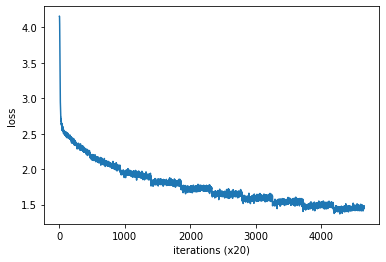

In [14]:
# CBOW training 

import sys
sys.path.append('..')
import numpy as np
from common import config


# To enable GPU, remove # in the line below
#config.GPU=True

import pickle
from cbow import CBOW
from common.trainer import Trainer
from common.optimizer import Adam
from common.util import create_contexts_target, to_cpu, to_gpu
from dataset import ptb

window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)
if config.GPU:
    contexts, target = to_gpu(contexts), to_gpu(target)
    
model = CBOW(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

In [15]:
# Saving the model

word_vecs = model.word_vecs
if config.GPU:
    word_vecs = to_cpu(word_vecs)
params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params.pkl'
with open(pkl_file,'wb') as f:
    pickle.dump(params,f,-1)

In [16]:
# Evaluation

import sys
sys.path.append('..')
from common.util import most_similar
import pickle

pkl_file = 'cbow_params.pkl'

with open(pkl_file, 'rb') as f:
    params = pickle.load(f)
    word_vecs = params['word_vecs']
    word_to_id = params['word_to_id']
    id_to_word = params['id_to_word']

querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


[query] you
we: 0.7294921875
i: 0.71484375
your: 0.59912109375
they: 0.59033203125
anybody: 0.58544921875

[query] year
month: 0.8544921875
week: 0.78076171875
summer: 0.7568359375
spring: 0.75146484375
decade: 0.693359375

[query] car
auto: 0.6162109375
luxury: 0.58935546875
cars: 0.56591796875
truck: 0.564453125
window: 0.56201171875

[query] toyota
honda: 0.63427734375
nissan: 0.63232421875
seita: 0.60546875
mazda: 0.5986328125
f-14: 0.59375


In [17]:
from common.util import analogy
analogy('king','man','queen',word_to_id,id_to_word,word_vecs)
analogy('take','took','go',word_to_id,id_to_word,word_vecs)
analogy('car','cars','child',word_to_id,id_to_word,word_vecs)
analogy('good','better','bad',word_to_id,id_to_word,word_vecs)


[analogy] king:man = queen:?
 a.m: 5.76171875
 woman: 5.3046875
 lady: 4.68359375
 artist: 4.58984375
 wife: 4.5859375

[analogy] take:took = go:?
 eurodollars: 5.84765625
 're: 4.4375
 came: 4.1015625
 were: 4.05078125
 went: 4.00390625

[analogy] car:cars = child:?
 a.m: 6.7265625
 rape: 5.81640625
 daffynition: 5.74609375
 children: 5.25
 incest: 4.9375

[analogy] good:better = bad:?
 rather: 6.390625
 more: 5.7421875
 less: 5.62109375
 greater: 4.59765625
 faster: 4.05859375


NOTE : PTB 데이터셋이 작기 때문에, 위의 결과에서 약간의 오류가 보인다. 아주 큰 말뭉치로 학습하면 더 좋은 결과를 기대할 수 있을 것이다.

## 3. Topics

### (1) 전이학습

분산 모델을 통해 자연어를 학습 가능한 데이터로 변환하는 예시를 지금까지 봤다.

특히 신경망 word2vec의 CBOW (또는 skip-gram)를 이용한 분산 모델은 전이학습에 유용하다.

1. 매우 큰 말뭉치 (wikipedia, google news, ...)를 이용해 학습된 파라미터를 가지고 각자의 작업에 이용.<br>
    (텍스트 분류, 문서 클러스터링, 품사 태그, 감정 분석, ...) 의 작업의 모델 데이터로 분산 모델의 결과를 이용할 수 있다.
2. 고정길이 벡터 (K차원의 벡터)로 변환해주기 때문에, 문장 또한 고정길이로 변환 가능.<br>
    Example: bag-of-words (각 단어의 합을 구하기, 순서 무관.), RNN을 이용한 문장 변환.
3. 벡터로 변환했기 때문에 이를 SVM, 신경망 등의 모델에 넣을 수 있다는 장점이 있다.<br>

### (2) 단어 벡터 평가 방법

단어의 분산 표현을 그 자체로 평가하기 위해 '유사성' 또는 '유추 문제'를 활용한다.

1. 유사성 평가 : 유사도를 0에서 10 사이로 점수화 했을 때, 단어들 사이의 코사인 유사도와 사람이 부여한 점수를 비교한다.
2. 유추 문제 : 유추 문제 (ex: king : queen = man : ?) 를 제시하고 이 정답률을 평가 지표로 삼는다.